# Noise map generation

We intoroduce the way how to generate noise map after the observation.


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from sbm import Field, ScanFields, SignalFields, plot_maps
import litebird_sim as lbs

In [2]:
# Load single detector map
scan_field = ScanFields.load_det("boresight/boresight")

In [3]:
# We assume that the noise is white noise, and ssingle detector on the boresight has a NET of 100 uK√s
net_ukrts = 100
scan_field.generate_noise_pdf(net_ukrts=net_ukrts)
mdim = 3
seed = 12345
# To generate noise map after the scanning, just call the generate_noise method
noise_map = scan_field.generate_noise(mdim, seed)

Once a hitmap is given, we can calculate the $\sigma$ of the noise per sky pixel as following:

$$
\sigma_T = \sqrt{\frac{s f_s}{N_{\rm hits}}} \rm{NET}
$$

$$
\sigma_{Q,U} = \frac{\sigma_T}{\sqrt{2}}
$$

where $s$ is integer which we call scaling factor.
When we simulate differential signal, the `SBM` takes into account only `Top` detectors without adding `Bottom` detectors. So that we have to compensate the statistics given by the hit-map. In this case, to set `s=2` is appropriate.

Now, we define the matrix $M$ which appears in a map-making equation.

$$
M = \begin{pmatrix}
1 & \frac{1}{2} {}_{-2}\tilde{h} & \frac{1}{2} {}_{2}\tilde{h} \\
\frac{1}{2} {}_{2}\tilde{h} & \frac{1}{4} & \frac{1}{4} {}_{4}\tilde{h} \\
\frac{1}{2} {}_{-2}\tilde{h} & \frac{1}{4} {}_{-4}\tilde{h} & \frac{1}{4}
\end{pmatrix}
$$

Then, the noise map can be given as follows:

$$
\Delta I = G(\sigma_T)\sqrt{\Re[(M^{-1})_{00}]}
$$

$$
\Delta Q, \Delta U   = G(\sigma_P)\sqrt{\Re[(M^{-1})_{11}]}
$$

where $G$ represents the sampling by Gaussian.


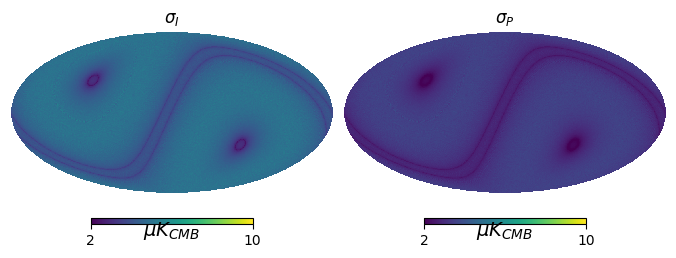

In [4]:
plt.figure(figsize=(10,5))
hp.mollview(scan_field.noise_pdf[0], sub=(1,3,1), title=r"$\sigma_I$", unit=r"$\mu K_{CMB}$", min=2, max=10)
hp.mollview(scan_field.noise_pdf[1], sub=(1,3,2), title=r"$\sigma_P$", unit=r"$\mu K_{CMB}$", min=2, max=10)

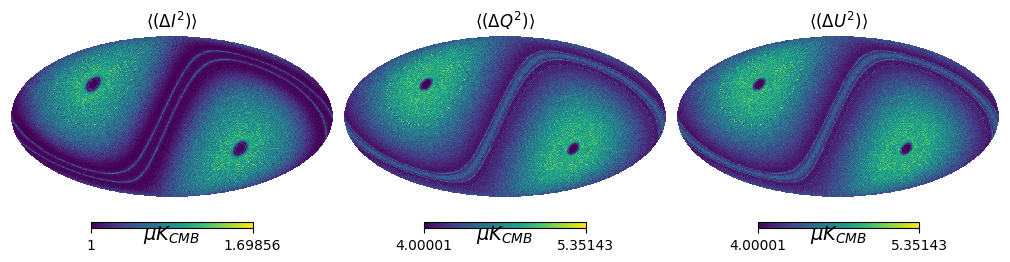

In [5]:
ii = scan_field.covmat_inv[0,0,:].real**2
qq = scan_field.covmat_inv[1,1,:].real**2
uu = qq
stokes_cov = np.array([ii, qq, uu])

plt.figure(figsize=(10,5))
hp.mollview(stokes_cov[0], sub=(1,3,1), title=r"$\langle (\Delta I^2) \rangle$", unit=r"$\mu K_{CMB}$")
hp.mollview(stokes_cov[1], sub=(1,3,2), title=r"$\langle (\Delta Q^2) \rangle$", unit=r"$\mu K_{CMB}$")
hp.mollview(stokes_cov[2], sub=(1,3,3), title=r"$\langle (\Delta U^2) \rangle$", unit=r"$\mu K_{CMB}$")

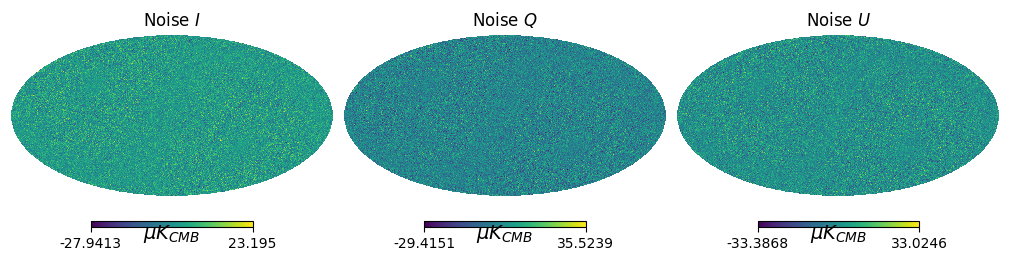

In [6]:
plt.figure(figsize=(10,5))
hp.mollview(noise_map[0], sub=(1,3,1), title="Noise $I$", unit=r"$\mu K_{CMB}$")
hp.mollview(noise_map[1], sub=(1,3,2), title="Noise $Q$", unit=r"$\mu K_{CMB}$")
hp.mollview(noise_map[2], sub=(1,3,3), title="Noise $U$", unit=r"$\mu K_{CMB}$")

In [7]:
N = 100
noise_maps = [scan_field.generate_noise(mdim, i) for i in range(N)]
nls = np.array([hp.anafast(noise_maps[i]) for i in range(N)])
nls_realized = nls.mean(0)

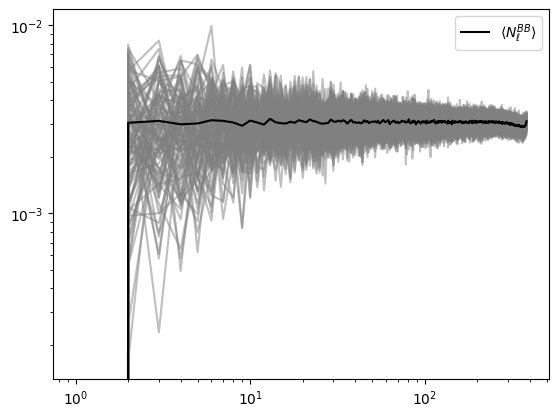

In [8]:
for i in range(N):
    plt.loglog(nls[i][2], color="gray", alpha=0.5)

plt.loglog(nls_realized[2], label=r"$\langle N_\ell^{BB} \rangle$", color="black")
plt.legend();